<a href="https://colab.research.google.com/github/SRARNAB7/HDS_5320_Group_Project/blob/main/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder # To work with the categorical Features in the dataset
from imblearn.over_sampling import SMOTE # To do sampling when required for class imbalace
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV # Used CV serach since Grid search can take more time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle # For saving the Models

In [21]:
#Reading the CSV file
df = pd.read_csv("/content/train.csv")

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               800 non-null    int64  
 1   A1_Score         800 non-null    int64  
 2   A2_Score         800 non-null    int64  
 3   A3_Score         800 non-null    int64  
 4   A4_Score         800 non-null    int64  
 5   A5_Score         800 non-null    int64  
 6   A6_Score         800 non-null    int64  
 7   A7_Score         800 non-null    int64  
 8   A8_Score         800 non-null    int64  
 9   A9_Score         800 non-null    int64  
 10  A10_Score        800 non-null    int64  
 11  age              800 non-null    float64
 12  gender           800 non-null    object 
 13  ethnicity        800 non-null    object 
 14  jaundice         800 non-null    object 
 15  austim           800 non-null    object 
 16  contry_of_res    800 non-null    object 
 17  used_app_before 

In [23]:
#convert Age column to int
df["age"] = df["age"].astype(int)

In [24]:
for col in df.columns:
  numerical_features = ["ID", "age", "result"]
  if col not in numerical_features:
    print(col, df[col].unique())
    print("_"*50)

A1_Score [1 0]
__________________________________________________
A2_Score [0 1]
__________________________________________________
A3_Score [1 0]
__________________________________________________
A4_Score [0 1]
__________________________________________________
A5_Score [1 0]
__________________________________________________
A6_Score [0 1]
__________________________________________________
A7_Score [1 0]
__________________________________________________
A8_Score [0 1]
__________________________________________________
A9_Score [1 0]
__________________________________________________
A10_Score [1 0]
__________________________________________________
gender ['f' 'm']
__________________________________________________
ethnicity ['?' 'White-European' 'Middle Eastern ' 'Pasifika' 'Black' 'Others'
 'Hispanic' 'Asian' 'Turkish' 'South Asian' 'Latino' 'others']
__________________________________________________
jaundice ['no' 'yes']
__________________________________________________
austim

In [25]:
#dropping ID and age_desc columns
df = df.drop(columns = ['ID',"age_desc"])

In [26]:
#define the mapping dictionary for country names
mapping = {
    "Viet Nam" : "Vietnam",
    "AmericanSamoa" : "United States",
    "Hong Kong" : "China"
}

df["contry_of_res"] = df["contry_of_res"].replace(mapping)

In [27]:
#Target Class Distribution
df["Class/ASD"].value_counts()

,count
Class/ASD,
0,639
1,161


In [28]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,f,?,no,no,Austria,no,6.351166,Self,0
1,0,0,0,0,0,0,0,0,0,0,47,m,?,no,no,India,no,2.255185,Self,0
2,1,1,1,1,1,1,1,1,1,1,7,m,White-European,no,yes,United States,no,14.851484,Self,1
3,0,0,0,0,0,0,0,0,0,0,23,f,?,no,no,United States,no,2.276617,Self,0
4,0,0,0,0,0,0,0,0,0,0,43,m,?,no,no,South Africa,no,-4.777286,Self,0


In [29]:
df["ethnicity"] = df["ethnicity"].replace({"?": "Others", "others": "Others"})

In [30]:
df["relation"] = df["relation"].replace({"?": "Others",
                                          "Relative": "Others",
                                          "Parent": "Others",
                                          "Health care professional" : "Others"})

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    object 
 12  ethnicity        800 non-null    object 
 13  jaundice         800 non-null    object 
 14  austim           800 non-null    object 
 15  contry_of_res    800 non-null    object 
 16  used_app_before  800 non-null    object 
 17  result          

In [32]:
df['Class/ASD'].isnull().any()

np.False_

In [33]:
#Identify columns with "object" data type
object_columns = df.select_dtypes(include = ["object"]).columns
print(object_columns)

Index(['gender', 'ethnicity', 'jaundice', 'austim', 'contry_of_res',
       'used_app_before', 'relation'],
      dtype='object')


In [34]:
#Initialize a dictionary  to store the encoders
encoders = {}
#Apply label encoding and store the encoders

for column in object_columns:
  label_encoder = LabelEncoder()
  df[column] = label_encoder.fit_transform(df[column])
  encoders[column] = label_encoder # saving  the encoder for this column

# save the encoders as a pickle file

with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders,f)

In [41]:
encoders

{'gender': LabelEncoder(),
 'ethnicity': LabelEncoder(),
 'jaundice': LabelEncoder(),
 'austim': LabelEncoder(),
 'contry_of_res': LabelEncoder(),
 'used_app_before': LabelEncoder(),
 'relation': LabelEncoder()}

In [35]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,relation,Class/ASD
0,1,0,1,0,1,0,1,0,1,1,38,0,5,0,0,6,0,6.351166,1,0
1,0,0,0,0,0,0,0,0,0,0,47,1,5,0,0,23,0,2.255185,1,0
2,1,1,1,1,1,1,1,1,1,1,7,1,9,0,1,52,0,14.851484,1,1
3,0,0,0,0,0,0,0,0,0,0,23,0,5,0,0,52,0,2.276617,1,0
4,0,0,0,0,0,0,0,0,0,0,43,1,5,0,0,44,0,-4.777286,1,0


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    int64  
 12  ethnicity        800 non-null    int64  
 13  jaundice         800 non-null    int64  
 14  austim           800 non-null    int64  
 15  contry_of_res    800 non-null    int64  
 16  used_app_before  800 non-null    int64  
 17  result          

FEATURE SELECTION

In [17]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from numpy import set_printoptions
X = df.drop(columns=['austim'])   # all features except target
y = df['austim']

# Define model
set_printoptions(precision=2)
selector = SelectKBest(score_func=chi2, k=4)

# Fit the selector
fit = selector.fit(X, y)
# Print scores for each feature
scores = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': fit.scores_
}).sort_values(by='Chi2 Score', ascending=False)

print(scores)

# Get the top 10 features
top_features = scores.nlargest(10, 'Chi2 Score')
print("\nTop 10 features:\n", top_features)

ValueError: Input X must be non-negative.

In [18]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# ----- Target -----
y = df['Class/ASD']

# ----- Features -----
# Drop target + redundant column
X = df.drop(columns=['Class/ASD'])

# One-hot encode categorical variables so Logistic Regression can handle them
X = pd.get_dummies(X, drop_first=True)

# Define base model
model = LogisticRegression(max_iter=1000, solver='liblinear')

# Apply RFE
rfe = RFE(model, n_features_to_select=8)
fit = rfe.fit(X, y)

# Rankings: 1 = selected feature, higher = less important
ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': fit.ranking_
}).sort_values(by='Ranking')

print("\nFeature Rankings:\n", ranking)

# Show selected features
selected = X.columns[fit.support_]
print("\nSelected top 3 features:\n", selected.tolist())



Feature Rankings:
             Feature  Ranking
3          A4_Score        1
2          A3_Score        1
5          A6_Score        1
4          A5_Score        1
6          A7_Score        1
7          A8_Score        1
8          A9_Score        1
18         relation        1
1          A2_Score        2
14           austim        3
0          A1_Score        4
11           gender        5
13         jaundice        6
9         A10_Score        7
12        ethnicity        8
16  used_app_before        9
17           result       10
10              age       11
15    contry_of_res       12

Selected top 3 features:
 ['A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'relation']


In [19]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
# ----- Target -----
y = df['Class/ASD']

# ----- Features -----
# Drop target + redundant 'austim'
X = df.drop(columns=['Class/ASD'])

model=ExtraTreesClassifier() # Define the model
model.fit(X,y)  # apply model over data
print(model.feature_importances_)

[0.02 0.03 0.04 0.08 0.05 0.13 0.05 0.04 0.07 0.02 0.1  0.03 0.06 0.03
 0.04 0.08 0.01 0.1  0.02]


| Feature           | Importance |
| ----------------- | ---------- |
| A1\_Score         | 0.02       |
| A2\_Score         | 0.03       |
| A3\_Score         | 0.04       |
| A4\_Score         | 0.07       |
| A5\_Score         | 0.06       |
| A6\_Score         | 0.14       |
| A7\_Score         | 0.05       |
| A8\_Score         | 0.04       |
| A9\_Score         | 0.06       |
| A10\_Score        | 0.02       |
| age               | 0.10       |
| gender            | 0.03       |
| ethnicity         | 0.06       |
| jaundice          | 0.03       |
| austim            | 0.04       |
| contry\_of\_res   | 0.08       |
| used\_app\_before | 0.01       |
| result            | 0.10       |
| relation          | 0.02       |


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         800 non-null    int64  
 1   A2_Score         800 non-null    int64  
 2   A3_Score         800 non-null    int64  
 3   A4_Score         800 non-null    int64  
 4   A5_Score         800 non-null    int64  
 5   A6_Score         800 non-null    int64  
 6   A7_Score         800 non-null    int64  
 7   A8_Score         800 non-null    int64  
 8   A9_Score         800 non-null    int64  
 9   A10_Score        800 non-null    int64  
 10  age              800 non-null    int64  
 11  gender           800 non-null    int64  
 12  ethnicity        800 non-null    int64  
 13  jaundice         800 non-null    int64  
 14  austim           800 non-null    int64  
 15  contry_of_res    800 non-null    int64  
 16  used_app_before  800 non-null    int64  
 17  result          

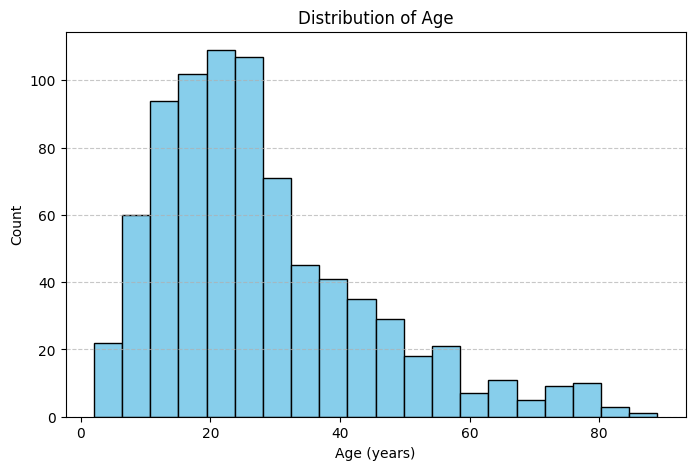

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df['age'], bins=20, edgecolor='black', color='skyblue')
plt.xlabel("Age (years)")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


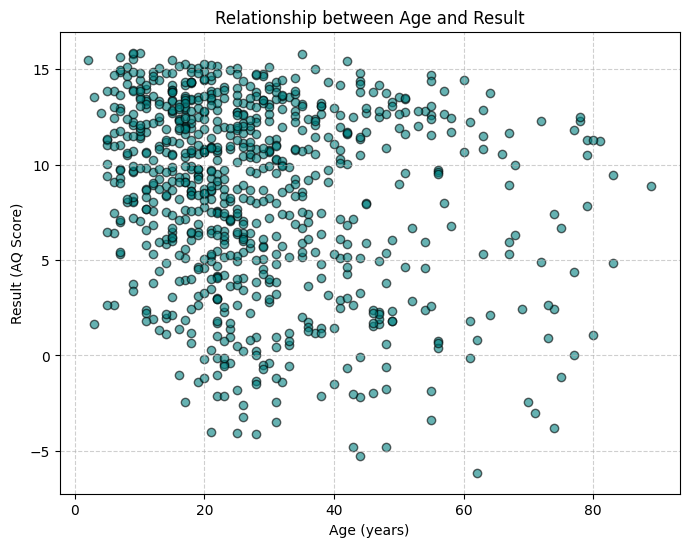

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df['age'], df['result'], alpha=0.6, color='teal', edgecolors='k')
plt.xlabel("Age (years)")
plt.ylabel("Result (AQ Score)")
plt.title("Relationship between Age and Result")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [42]:
# Example: check the mapping for gender
print(encoders['gender'].classes_) #0 is female and 1 is male


['f' 'm']


<Axes: xlabel='gender'>

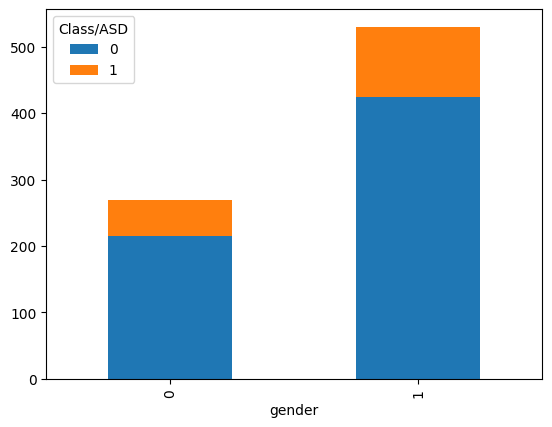

In [40]:
pd.crosstab(df['gender'], df['Class/ASD']).plot(kind='bar', stacked=True)


<Axes: xlabel='Class/ASD', ylabel='result'>

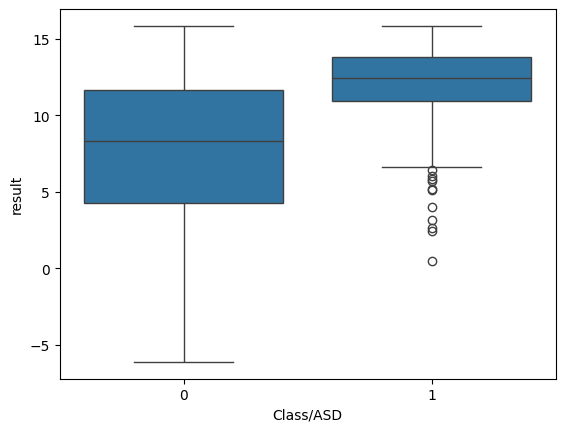

In [44]:
import seaborn as sns
sns.boxplot(x='Class/ASD', y='result', data=df)


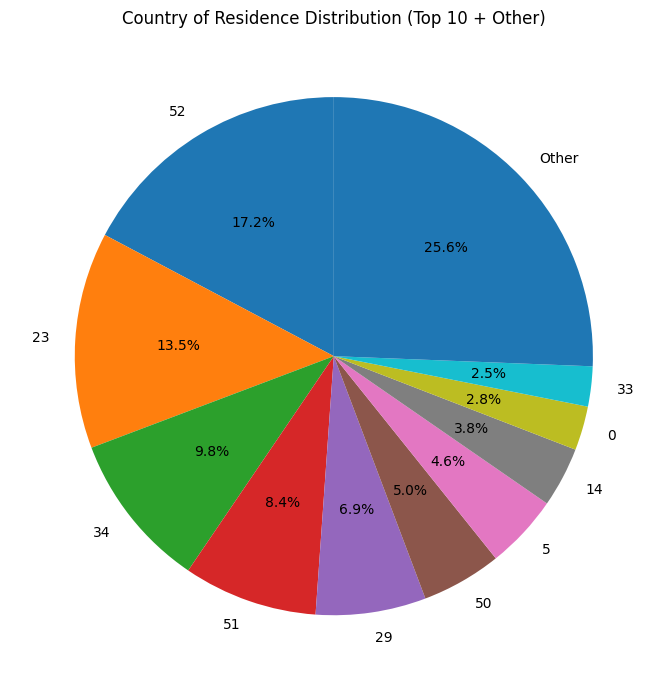

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Get top 10 countries, group the rest as 'Other'
top_n = 10
country_counts = df['contry_of_res'].value_counts()
top_countries = country_counts.head(top_n)
other = pd.Series({'Other': country_counts.iloc[top_n:].sum()})
country_counts = pd.concat([top_countries, other])

# Pie chart
plt.figure(figsize=(7,7))
plt.pie(country_counts.values, labels=country_counts.index,
        autopct='%1.1f%%', startangle=90)
plt.title("Country of Residence Distribution (Top 10 + Other)")
plt.tight_layout()
plt.show()


In [46]:
print(encoders['contry_of_res'].classes_)

['Afghanistan' 'Angola' 'Argentina' 'Armenia' 'Aruba' 'Australia'
 'Austria' 'Azerbaijan' 'Bahamas' 'Bangladesh' 'Belgium' 'Bolivia'
 'Brazil' 'Burundi' 'Canada' 'China' 'Cyprus' 'Czech Republic' 'Egypt'
 'Ethiopia' 'France' 'Germany' 'Iceland' 'India' 'Iran' 'Iraq' 'Ireland'
 'Italy' 'Japan' 'Jordan' 'Kazakhstan' 'Malaysia' 'Mexico' 'Netherlands'
 'New Zealand' 'Nicaragua' 'Niger' 'Oman' 'Pakistan' 'Romania' 'Russia'
 'Saudi Arabia' 'Serbia' 'Sierra Leone' 'South Africa' 'Spain' 'Sri Lanka'
 'Sweden' 'Tonga' 'Ukraine' 'United Arab Emirates' 'United Kingdom'
 'United States' 'Vietnam']


In [48]:
# Gender vs ASD
gender_ct = pd.crosstab(df['gender'], df['Class/ASD'])
print("Gender vs ASD:\n", gender_ct)

# Ethnicity vs ASD
ethnicity_ct = pd.crosstab(df['ethnicity'], df['Class/ASD'])
print("\nEthnicity vs ASD:\n", ethnicity_ct)


Gender vs ASD:
 Class/ASD    0    1
gender             
0          215   55
1          424  106

Ethnicity vs ASD:
 Class/ASD    0    1
ethnicity          
0           63    4
1           41    6
2            7    2
3           13    4
4           91    6
5          226    9
6           26    6
7           31    3
8            5    0
9          136  121


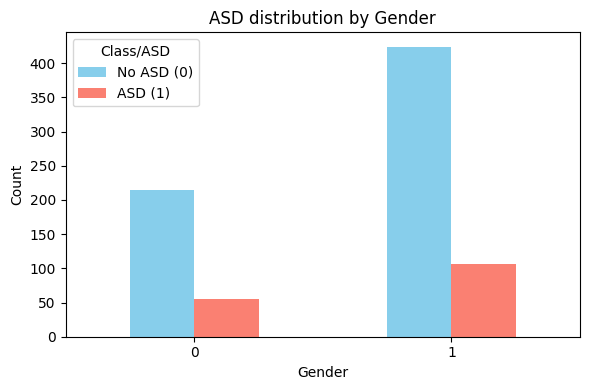

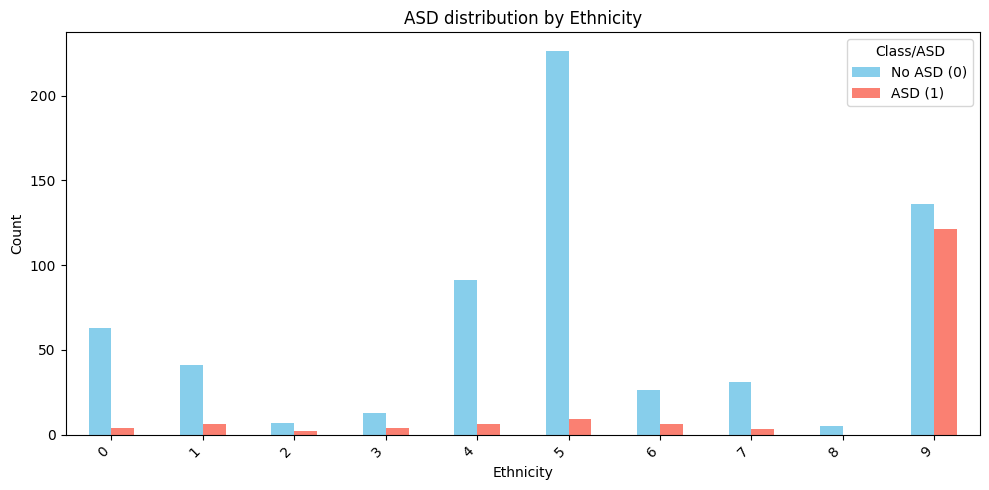

In [49]:
import matplotlib.pyplot as plt

# --- Gender vs ASD ---
gender_ct.plot(kind="bar", stacked=False, figsize=(6,4), color=["skyblue","salmon"])
plt.title("ASD distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.tight_layout()
plt.show()

# --- Ethnicity vs ASD ---
ethnicity_ct.plot(kind="bar", stacked=False, figsize=(10,5), color=["skyblue","salmon"])
plt.title("ASD distribution by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Class/ASD", labels=["No ASD (0)", "ASD (1)"])
plt.tight_layout()
plt.show()
